In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import matplotlib.image

#!pip install webcolors
import webcolors

In [2]:
class_colormap = pd.read_csv("/opt/ml/input/code/class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [3]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [4]:
dataset_path  = '/opt/ml/input/data/data_new/images/'
anns_file_path = '/opt/ml/input/data/data_new/train_new.json' # validation set에 대해서도 해야함

In [5]:
%matplotlib inline

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 20988
Number of images: 2617


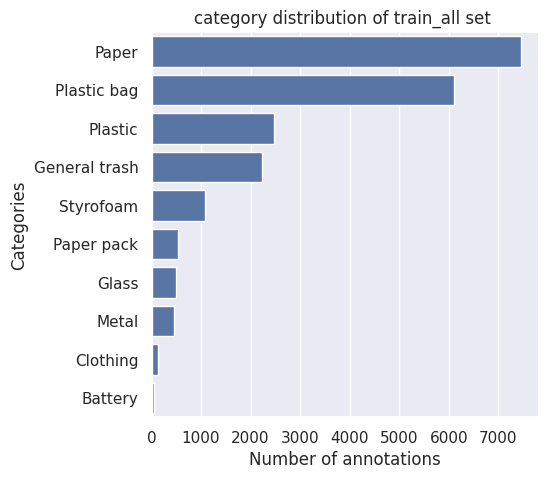

In [6]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [7]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [8]:
category_names = list(sorted_df.Categories)

In [9]:
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=4.36s)
creating index...
index created!


In [10]:
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)
sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
category_names = list(sorted_df.Categories)

In [11]:
for index in range(len(coco.getImgIds())):
    image_id = coco.getImgIds(imgIds=index)
    image_infos = coco.loadImgs(image_id)[0]
    # print(image_infos)
    images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
    images /= 255.0

    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    # masks : size가 (height x width)인 2D
    # 각각의 pixel 값에는 "category id" 할당
    # Background = 0
    masks = np.zeros((image_infos["height"], image_infos["width"]))
    # General trash = 1, ... , Cigarette = 10
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)

    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)
    # masks = label_to_color_image(masks)
    # plt.imsave('/opt/ml/input/data/data_new/annotations/' + image_infos['file_name'].split('.')[0] + '.png', masks, cmap='gray')
    cv2.imwrite('/opt/ml/input/data/data_new/annotations/' + image_infos['file_name'].split('.')[0] + '.png', masks)
    
    # matplotlib.image.imsave('/opt/ml/input/data/data_new/annotations/' + image_infos['file_name'].split('.')[0] + '.png', masks)